In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectKBest, f_regression


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pd.read_csv("/content/drive/MyDrive/AI work/AB_NYC_2019.csv")

print(df.head())
print(df.info())


     id                                              name  host_id  \
0  2539                Clean & quiet apt home by the park     2787   
1  2595                             Skylit Midtown Castle     2845   
2  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
3  3831                   Cozy Entire Floor of Brownstone     4869   
4  5022  Entire Apt: Spacious Studio/Loft by central park     7192   

     host_name neighbourhood_group neighbourhood  latitude  longitude  \
0         John            Brooklyn    Kensington  40.64749  -73.97237   
1     Jennifer           Manhattan       Midtown  40.75362  -73.98377   
2    Elisabeth           Manhattan        Harlem  40.80902  -73.94190   
3  LisaRoxanne            Brooklyn  Clinton Hill  40.68514  -73.95976   
4        Laura           Manhattan   East Harlem  40.79851  -73.94399   

         room_type  price  minimum_nights  number_of_reviews last_review  \
0     Private room    149               1                  9  20

In [5]:
df = df.drop(["id","name","host_name","last_review"], axis=1)


In [6]:
df["reviews_per_month"] = df["reviews_per_month"].fillna(0)


In [7]:
df = df[df["price"] < 500]


In [8]:
le = LabelEncoder()

df["neighbourhood_group"] = le.fit_transform(df["neighbourhood_group"])
df["neighbourhood"] = le.fit_transform(df["neighbourhood"])
df["room_type"] = le.fit_transform(df["room_type"])


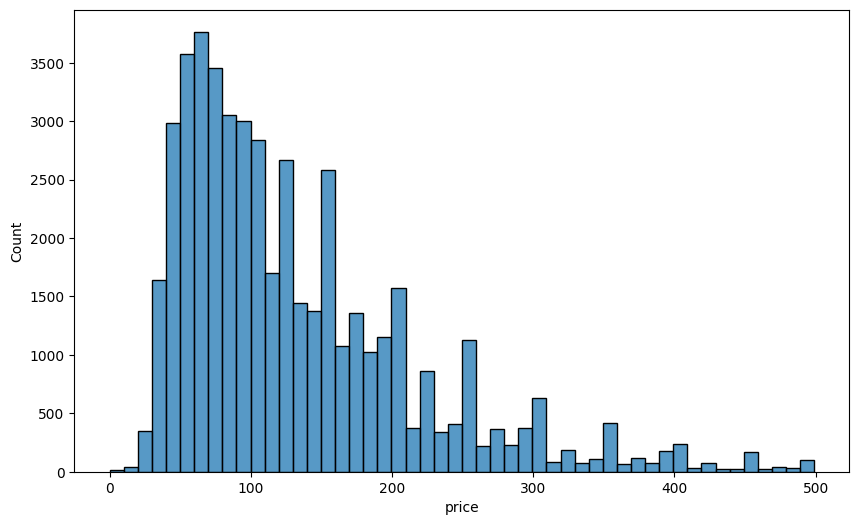

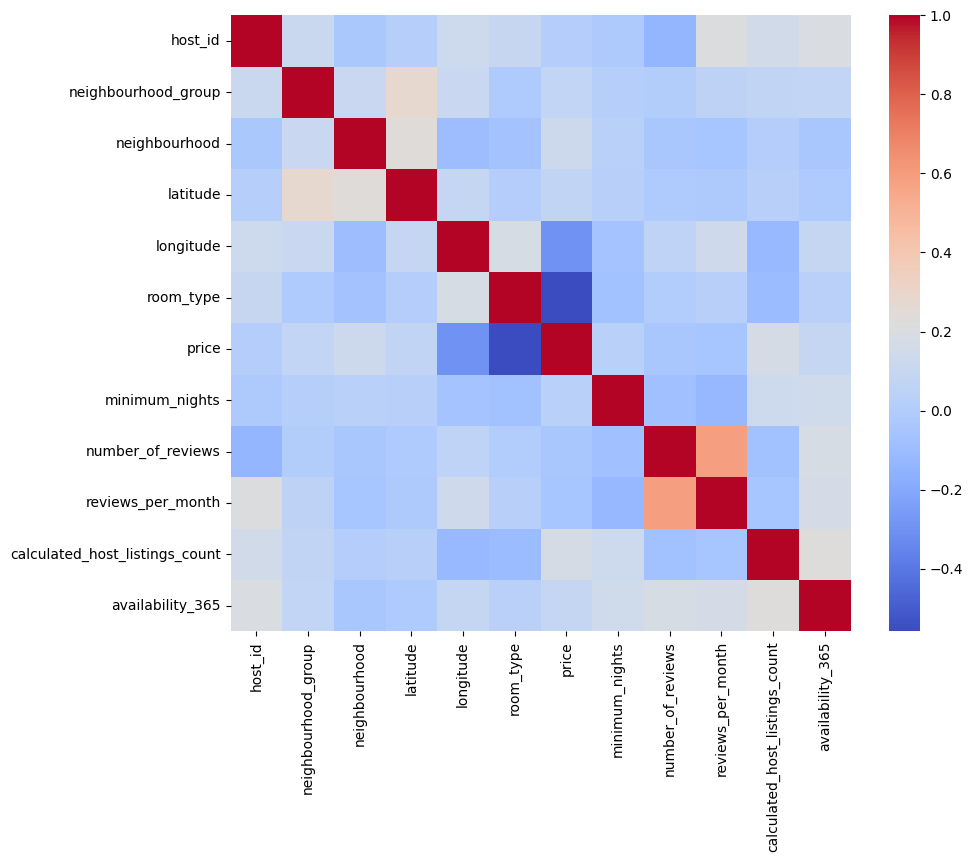

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(df["price"], bins=50)
plt.show()

plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), cmap="coolwarm")
plt.show()


In [10]:
target = "price"

X = df.drop(target, axis=1)
y = df[target]


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [12]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [14]:
nn = MLPRegressor(
    hidden_layer_sizes=(128,64),
    activation='relu',
    max_iter=300,
    random_state=42
)

nn.fit(X_train_scaled, y_train)

pred_nn = nn.predict(X_test_scaled)


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


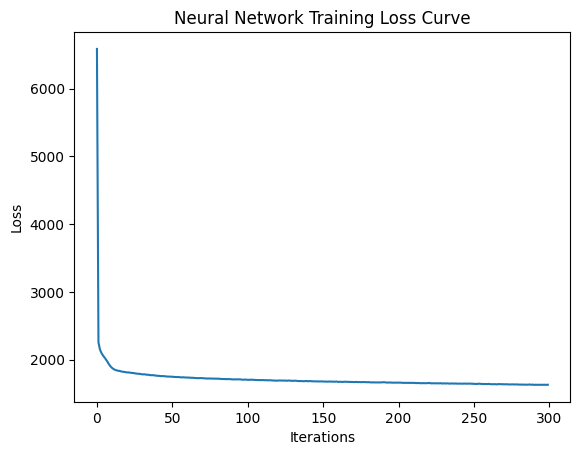

In [15]:
# Plot loss curve
plt.figure()
plt.plot(nn.loss_curve_)
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Neural Network Training Loss Curve")
plt.show()

In [16]:
ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)

pred_ridge = ridge.predict(X_test_scaled)


In [17]:
rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

pred_rf = rf.predict(X_test)


In [18]:
def evaluate(name, y_true, pred):
    print(name)
    print("RMSE:", np.sqrt(mean_squared_error(y_true, pred)))
    print("MAE:", mean_absolute_error(y_true, pred))
    print("R2:", r2_score(y_true, pred))
    print()

evaluate("Neural Network", y_test, pred_nn)
evaluate("Ridge", y_test, pred_ridge)
evaluate("Random Forest", y_test, pred_rf)


Neural Network
RMSE: 59.34542327542399
MAE: 40.27020261186129
R2: 0.5080612556559119

Ridge
RMSE: 66.30306244078861
MAE: 46.33399662195649
R2: 0.3859499920062911

Random Forest
RMSE: 57.90698106196844
MAE: 38.68665617568892
R2: 0.5316199241700885



In [19]:
param_grid = {
    'n_estimators':[200,300],
    'max_depth':[10,20,None],
    'min_samples_split':[2,5]
}

grid_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring='r2'
)

grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_

print(grid_rf.best_params_)
print(grid_rf.best_score_)


{'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}
0.5374213280204948


In [20]:
selector = SelectKBest(score_func=f_regression, k=8)

X_train_sel = selector.fit_transform(X_train_scaled, y_train)
X_test_sel = selector.transform(X_test_scaled)

selected_features = X.columns[selector.get_support()]

print("Selected Features:", selected_features)


Selected Features: Index(['neighbourhood_group', 'neighbourhood', 'latitude', 'longitude',
       'room_type', 'reviews_per_month', 'calculated_host_listings_count',
       'availability_365'],
      dtype='object')


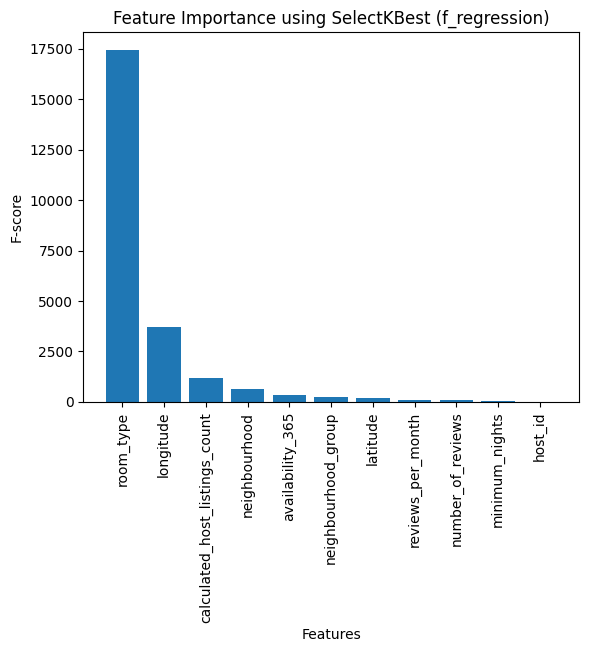

In [21]:
# Create DataFrame of feature scores
feature_scores = pd.DataFrame({
    "Feature": X.columns,
    "F_score": selector.scores_
})

# Sort by score
feature_scores = feature_scores.sort_values(by="F_score", ascending=False)

# Plot
plt.figure()
plt.bar(feature_scores["Feature"], feature_scores["F_score"])
plt.xticks(rotation=90)
plt.xlabel("Features")
plt.ylabel("F-score")
plt.title("Feature Importance using SelectKBest (f_regression)")
plt.show()

In [22]:
final_ridge = Ridge(alpha=1.0)
final_ridge.fit(X_train_sel, y_train)

pred_final_ridge = final_ridge.predict(X_test_sel)


In [23]:
best_rf.fit(X_train_sel, y_train)

pred_final_rf = best_rf.predict(X_test_sel)


In [24]:
def metrics(pred):
    return [
        np.sqrt(mean_squared_error(y_test, pred)),
        r2_score(y_test, pred)
    ]

rf_metrics = metrics(pred_final_rf)
ridge_metrics = metrics(pred_final_ridge)


In [25]:
results = pd.DataFrame({
    "Model":["Random Forest","Ridge Regression"],
    "Features Used":[len(selected_features), len(selected_features)],
    "CV Score":[grid_rf.best_score_, None],
    "Test RMSE":[rf_metrics[0], ridge_metrics[0]],
    "Test R-squared":[rf_metrics[1], ridge_metrics[1]]
})

print(results)


              Model  Features Used  CV Score  Test RMSE  Test R-squared
0     Random Forest              8  0.537421  59.277325        0.509190
1  Ridge Regression              8       NaN  66.608311        0.380283


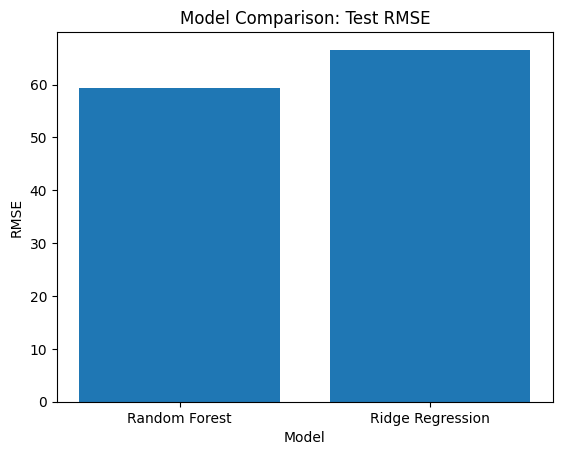

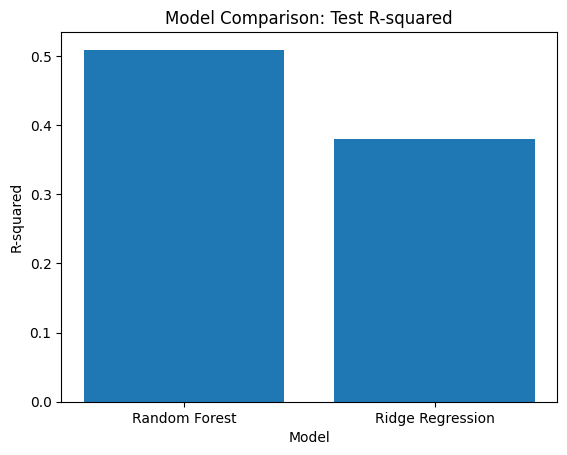

In [26]:


# Results DataFrame
results = pd.DataFrame({
    "Model": ["Random Forest", "Ridge Regression"],
    "Test RMSE": [59.277325, 66.608311],
    "Test R-squared": [0.509190, 0.380283]
})

# RMSE comparison plot
plt.figure()
plt.bar(results["Model"], results["Test RMSE"])
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.title("Model Comparison: Test RMSE")
plt.show()

# R-squared comparison plot
plt.figure()
plt.bar(results["Model"], results["Test R-squared"])
plt.xlabel("Model")
plt.ylabel("R-squared")
plt.title("Model Comparison: Test R-squared")
plt.show()
